In [59]:
# packages

import os
import numpy as np
import nibabel as nib
import pandas as pd
from nibabel.testing import data_path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.utils import shuffle

#### Preprocessing

In [60]:
# defining path

dataset = 'OAS2_RAW_PART1/'
excel_file = pd.read_excel('oasis_longitudinal_demographics.xlsx')

In [61]:
# defining different shapes for the images

full = pd.IndexSlice[:, :, :, 0]
half = pd.IndexSlice[::2, ::2, ::2, 0]
fourth = pd.IndexSlice[::4, ::4, ::4, 0]
eigth = pd.IndexSlice[::8, ::8, ::8, 0]
sixteenth = pd.IndexSlice[::16, ::16, ::16, 0]

full_shape = (256*256*128)
half_shape = (128*128*64)
fourth_shape = (64*64*32)
eigth_shape = (32*32*16)
sixteenth_shape = (16*16*8)

In [62]:
# opening reference excel file

data = pd.DataFrame(excel_file)

data.insert(15, 'Images', '')

data.insert(16, 'Cropped_1', '')
data.insert(17, 'Cropped_2', '')
data.insert(18, 'Cropped_3', '')
data.insert(19, 'Cropped_4', '')
data.insert(20, 'Cropped_5', '')
data.insert(21, 'Cropped_6', '')
data.insert(22, 'Cropped_7', '')
data.insert(23, 'Cropped_8', '')

data.insert(24, 'Cropped_1_1', '')
data.insert(25, 'Cropped_1_2', '')
data.insert(26, 'Cropped_1_3', '')
data.insert(27, 'Cropped_1_4', '')
data.insert(28, 'Cropped_1_5', '')
data.insert(29, 'Cropped_1_6', '')
data.insert(30, 'Cropped_1_7', '')
data.insert(31, 'Cropped_1_8', '')

# adding each (feature-reduced) image to the dataframe
for index, row in data.iterrows():
    for image in os.scandir(dataset+row['MRI ID']+'/RAW'):
        if image.name.endswith('img'):
            img = nib.load(image)
            data.at[index, 'Images'] = img.get_fdata()[fourth] # feature reduction
        # break because memory gets too large if every picture is added
        break

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subject ID   373 non-null    object 
 1   MRI ID       373 non-null    object 
 2   Group        373 non-null    object 
 3   Visit        373 non-null    int64  
 4   MR Delay     373 non-null    int64  
 5   M/F          373 non-null    object 
 6   Hand         373 non-null    object 
 7   Age          373 non-null    int64  
 8   EDUC         373 non-null    int64  
 9   SES          354 non-null    float64
 10  MMSE         371 non-null    float64
 11  CDR          373 non-null    float64
 12  eTIV         373 non-null    float64
 13  nWBV         373 non-null    float64
 14  ASF          373 non-null    float64
 15  Images       373 non-null    object 
 16  Cropped_1    373 non-null    object 
 17  Cropped_2    373 non-null    object 
 18  Cropped_3    373 non-null    object 
 19  Cropped_

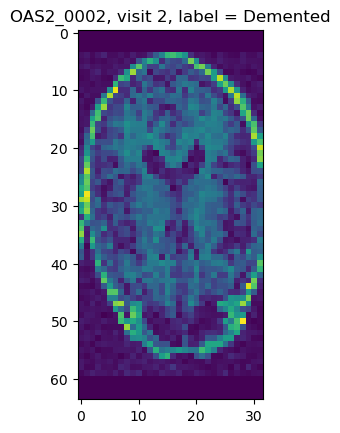

In [63]:
# info of put-together dataframe
print(data.info())

# plot example:
plt.imshow(data.iloc[3]['Images'][:, 40, :])
plt.title(f"{data.iloc[3]['Subject ID']}, visit {data.iloc[3]['Visit']}, label = {data.iloc[3]['Group']}")
plt.show()

In [64]:
# cropping images and adding to data, full shape = (64, 64, 32)

for index, row in data.iterrows():
                                  
    img1 = data.iloc[index]['Images'][32:65, 0:32, 16:33]
    data.at[index, 'Cropped_1'] = img1
                                   
    img2 = data.iloc[index]['Images'][32:65, 32:65, 0:16]
    data.at[index, 'Cropped_2'] = img2
                                    
    img3 = data.iloc[index]['Images'][32:65, 32:65, 16:33]
    data.at[index, 'Cropped_3'] = img3
    
    img4 = data.iloc[index]['Images'][0:32, 32:65, 0:16]
    data.at[index, 'Cropped_4'] = img4
                     
    img5 = data.iloc[index]['Images'][0:32, 0:32, 16:33]
    data.at[index, 'Cropped_5'] = img5
                                   
    img6 = data.iloc[index]['Images'][0:32, 0:32, 0:16]
    data.at[index, 'Cropped_6'] = img6
    
    img7 = data.iloc[index]['Images'][32:65, 0:32, 0:16]
    data.at[index, 'Cropped_7'] = img7
               
    img8 = data.iloc[index]['Images'][0:32, 32:65, 16:33]
    data.at[index, 'Cropped_8'] = img8

for index, row in data.iterrows():

    img1 = data.iloc[index]['Cropped_1'][16:33, 0:16, 8:17]
    data.at[index, 'Cropped_1_1'] = img1
                                   
    img2 = data.iloc[index]['Cropped_1'][16:33, 16:33, 0:8]
    data.at[index, 'Cropped_1_2'] = img2
                                    
    img3 = data.iloc[index]['Cropped_1'][16:33, 16:33, 8:17]
    data.at[index, 'Cropped_1_3'] = img3
    
    img4 = data.iloc[index]['Cropped_1'][0:16, 16:33, 0:8]
    data.at[index, 'Cropped_1_4'] = img4
                     
    img5 = data.iloc[index]['Cropped_1'][0:16, 0:16, 8:17]
    data.at[index, 'Cropped_1_5'] = img5
                                   
    img6 = data.iloc[index]['Cropped_1'][0:16, 0:16, 0:8]
    data.at[index, 'Cropped_1_6'] = img6
    
    img7 = data.iloc[index]['Cropped_1'][16:33, 0:16, 0:8]
    data.at[index, 'Cropped_1_7'] = img7
               
    img8 = data.iloc[index]['Cropped_1'][0:16, 16:33, 8:17]
    data.at[index, 'Cropped_1_8'] = img8

data = data[data.Group != 'Converted']

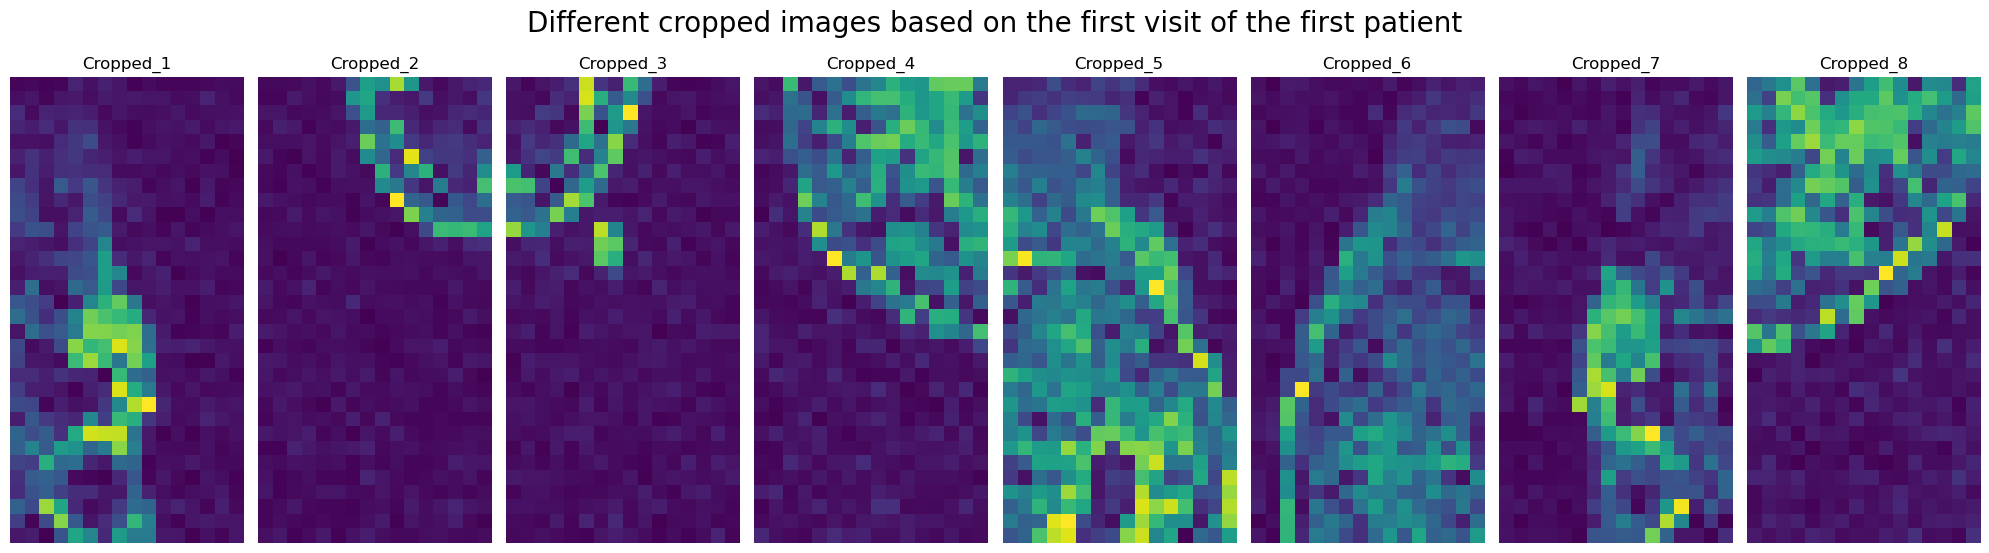

In [69]:
# visualization of different cropped dimensions

indeces = [16, 17, 18, 19, 20, 21, 22, 23]
fig, axes = plt.subplots(1, 8, figsize=(20,20))

for ax, index in zip(axes, indeces):
    ax.imshow(data.iloc[0][index][16, :, :])
    ax.axis('off')
    ax.title.set_text(data.columns[index])
fig.tight_layout()
fig.suptitle('Different cropped images based on the first visit of the first patient', y=0.65, fontsize=20)
plt.show()

### Full sized images classification

In [66]:
# converting to numpy because that is easier for algorithms
data_num = pd.DataFrame(data).to_numpy()

# defining images and target
for i in range(len(data_num[:, 15])):
    data_num[:, 15][i] = data_num[:, 15][i].reshape(fourth_shape)
    
X = data_num[:, 15]
# stacking so it gets the shape (373, 131072)
X = np.stack(X, axis=0)
y = data_num[:, 2]

# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

# shuffle because data is ordered
X, y = shuffle(X, y)

##################
#####  KNN  ######
##################

# testing for different amounts of neighbors
n_neighbors = [1, 3, 5, 7, 9, 11]

# cross validation
best = {}
fp = open("CV_scores_KNN_full.txt", "a")
for neighbor in n_neighbors:
    kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbor), X, y, cv = 10, 
                              n_jobs = 3, return_train_score = True)
    kNN_dict.pop('fit_time')
    kNN_dict.pop('score_time')
    # adding the average and standard deviation of the folds to a dictionary that keeps scores
    best[neighbor] = np.mean(kNN_dict['test_score']), np.std(kNN_dict['test_score'])
    fp.write(f"KNN with {neighbor} neighbors:\n{kNN_dict}\n")
fp.write(f"Best test score is {max(best.values())[0]} with n_neighbor = {max(best, key=best.get)} and standard deviation {max(best.values())[1]}\n")
fp.close()

##################
#####  SVM  ######
##################

C_value = [1, 50, 100]

best = {}
fp = open("CV_scores_SVM_full.txt", "a")
for value in C_value:
    SVM_dict = cross_validate(svm.SVC(kernel='rbf', C=value), X, y, cv = 10, n_jobs = 3, 
                              return_train_score = True)
    SVM_dict.pop('fit_time')
    SVM_dict.pop('score_time')
    # adding the average of the folds to a dictionary that keeps scores
    best[value] = np.mean(SVM_dict['test_score']), np.std(SVM_dict['test_score'])
    fp.write(f"SVM with C = {value}:\n{SVM_dict}\n")
fp.write(f"Best test score is {max(best.values())[0]} with C = {max(best, key=best.get)} and standard deviation {max(best.values())[1]}\n")
fp.close()



/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Cropped pictures classification

In [67]:
# testing for different neighbors -> KNN
n_neighbors = [1, 3, 5, 7, 9, 11]
# testing for different C values -> SVM
C_value = [1, 50, 100]

# choosing target which is the second column, namely 'Group'
# this stays the same for every cropped picture so shouldn't be in the loop
y = data_num[:, 2]
# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

best_test_KNN = {}
best_test_SVM = {}
fp = open("CV_scores_KNN_cropped.txt", "a")
file = open("CV_scores_SVM_cropped.txt", "a")

# defining images and target for every cropped picture
for i in range(16, 24):
    for j in range(len(data_num[:, i])):
        data_num[:, i][j] = data_num[:, i][j].reshape(32*32*16)
    X = data_num[:, i]
    # stacking so it gets the shape (373, 16384)
    X = np.stack(X, axis=0)

    # shuffle because data is ordered
    X, y = shuffle(X, y)
  
    fp.write(f"Scores for {data.columns[i]}\n")
    file.write(f"Scores for {data.columns[i]}\n")

    ##################
    #####  KNN  ######
    ##################
    
    best_KNN = {}
    for neighbor in n_neighbors:
        kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbor), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        kNN_dict.pop('fit_time')
        kNN_dict.pop('score_time')
        # adding the average and standard deviation of the folds to a dictionary that keeps scores
        best_KNN[neighbor] = np.mean(kNN_dict['test_score']), np.std(kNN_dict['test_score'])
        fp.write(f"KNN with {neighbor} neighbors:\n{kNN_dict}\n")
    # best_test_KNN will have the format {cropped_picture: [(best_mean, standard deviation), n_neighbors]}
    best_test_KNN[data.columns[i]] = [max(best_KNN.values()), max(best_KNN, key=best_KNN.get)]

    ##################
    #####  SVM  ######
    ##################

    best_SVM = {}
    for value in C_value:
        SVM_dict = cross_validate(svm.SVC(kernel='rbf', C=value), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        SVM_dict.pop('fit_time')
        SVM_dict.pop('score_time')
        # adding the average of the folds to a dictionary that keeps scores
        best_SVM[value] = np.mean(SVM_dict['test_score']), np.std(SVM_dict['test_score'])
        file.write(f"SVM with C = {value}:\n{SVM_dict}\n")
    # best_test_SVM will have the format {cropped_picture: [(best_mean, standard deviation), C_value]}
    best_test_SVM[data.columns[i]] = [max(best_SVM.values()), max(best_SVM, key=best_SVM.get)]
     
    fp.write("\n")
    file.write("\n")
    
fp.write(f"{max(best_test_KNN, key=best_test_KNN.get)} has the best test score ({max(best_test_KNN.values())[0][0]}) with n_neighbor = {max(best_test_KNN.values())[1]} and standard deviation {max(best_test_KNN.values())[0][1]} ")
fp.close()
file.write(f"{max(best_test_SVM, key=best_test_SVM.get)} has the best test score ({max(best_test_SVM.values())[0][0]}) with C = {max(best_test_SVM.values())[1]} and standard deviation {max(best_test_SVM.values())[0][1]}")
file.close()


In [70]:
print(best_test_KNN)
print(best_test_SVM)

{'Cropped_1': [(0.5861853832442068, 0.0668568616783843), 7], 'Cropped_2': [(0.5472370766488414, 0.0470922341289556), 11], 'Cropped_3': [(0.5722816399286987, 0.08170475323760705), 9], 'Cropped_4': [(0.536096256684492, 0.06492091423977767), 3], 'Cropped_5': [(0.5715686274509805, 0.0788798251205498), 3], 'Cropped_6': [(0.5621212121212122, 0.06815478359092995), 1], 'Cropped_7': [(0.5122103386809269, 0.06139138100830665), 11], 'Cropped_8': [(0.5600713012477719, 0.08076577830916634), 9]}
{'Cropped_1': [(0.6074866310160428, 0.044406497824139524), 50], 'Cropped_2': [(0.5533868092691623, 0.056260606940514185), 1], 'Cropped_3': [(0.5805704099821748, 0.06516876513629896), 100], 'Cropped_4': [(0.5569518716577541, 0.0425245783941909), 1], 'Cropped_5': [(0.5773618538324421, 0.04117569892247896), 1], 'Cropped_6': [(0.5536541889483066, 0.04288423312693221), 1], 'Cropped_7': [(0.5327985739750446, 0.04706827539713706), 1], 'Cropped_8': [(0.57174688057041, 0.05705527060748053), 1]}


### Focusing on best performing cropped picture
For both SVM and KNN, Cropped_1 performed best

In [72]:
# testing for different neighbors -> KNN
n_neighbors = [1, 3, 5, 7, 9, 11]
# testing for different C values -> SVM
C_value = [1, 50, 100]

# choosing target which is the second column, namely 'Group'
# this stays the same for every cropped picture so shouldn't be in the loop
y = data_num[:, 2]
# converting strings to integers where 'Nondemented' = 0 and 'Demented' = 1
y = np.where(y == 'Nondemented', 0, 1)

best_test_KNN = {}
best_test_SVM = {}
fp = open("CV_scores_KNN_cropped_1.txt", "a")
file = open("CV_scores_SVM_cropped_1.txt", "a")

# defining images and target for every cropped picture
for i in range(24, 32):
    for j in range(len(data_num[:, i])):
        data_num[:, i][j] = data_num[:, i][j].reshape(16*16*8)
    X = data_num[:, i]
    # stacking so it gets the shape (373, 16384)
    X = np.stack(X, axis=0)

    # shuffle because data is ordered
    X, y = shuffle(X, y)
  
    fp.write(f"Scores for {data.columns[i]}\n")
    file.write(f"Scores for {data.columns[i]}\n")

    ##################
    #####  KNN  ######
    ##################
    
    best_KNN = {}
    for neighbor in n_neighbors:
        kNN_dict = cross_validate(KNeighborsClassifier(n_neighbors = neighbor), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        kNN_dict.pop('fit_time')
        kNN_dict.pop('score_time')
        # adding the average and standard deviation of the folds to a dictionary that keeps scores
        best_KNN[neighbor] = np.mean(kNN_dict['test_score']), np.std(kNN_dict['test_score'])
        fp.write(f"KNN with {neighbor} neighbors:\n{kNN_dict}\n")
    # best_test_KNN will have the format {cropped_picture: [(best_mean, standard deviation), n_neighbors]}
    best_test_KNN[data.columns[i]] = [max(best_KNN.values()), max(best_KNN, key=best_KNN.get)]

    ##################
    #####  SVM  ######
    ##################

    best_SVM = {}
    for value in C_value:
        SVM_dict = cross_validate(svm.SVC(kernel='rbf', C=value), X, y, cv = 10, n_jobs = 3, return_train_score = True)
        SVM_dict.pop('fit_time')
        SVM_dict.pop('score_time')
        # adding the average of the folds to a dictionary that keeps scores
        best_SVM[value] = np.mean(SVM_dict['test_score']), np.std(SVM_dict['test_score'])
        file.write(f"SVM with C = {value}:\n{SVM_dict}\n")
    # best_test_SVM will have the format {cropped_picture: [(best_mean, standard deviation), C_value]}
    best_test_SVM[data.columns[i]] = [max(best_SVM.values()), max(best_SVM, key=best_SVM.get)]
     
    fp.write("\n")
    file.write("\n")
    
fp.write(f"{max(best_test_KNN, key=best_test_KNN.get)} has the best test score ({max(best_test_KNN.values())[0][0]}) with n_neighbor = {max(best_test_KNN.values())[1]} and standard deviation {max(best_test_KNN.values())[0][1]} ")
fp.close()
file.write(f"{max(best_test_SVM, key=best_test_SVM.get)} has the best test score ({max(best_test_SVM.values())[0][0]}) with C = {max(best_test_SVM.values())[1]} and standard deviation {max(best_test_SVM.values())[0][1]}")
file.close()


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
